In [44]:
import numpy as np
import tifffile as tf
import ntpath
import fnmatch
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import time
import math
from utils.paq2py import *
from utils.parse_markpoints import ParseMarkpoints
from utils.utils_funcs import *
import seaborn as sns
from random import randint
from scipy import stats
import csv

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',}
plt.rcParams.update(params)
sns.set()
sns.set_style('whitegrid')
#%matplotlib notebook

In [34]:
#the path to your paq file
paq_path = r"C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004\2019-04-25_RL036_t-004.paq"
#the path to the umbrella suite2p file
s2p_path = r"C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004"
#the path to your naparm folder with FOVTarget files
naparm_path = r"C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004\2019-04-25_RL036_NAPARM_004"
#the path to your opsin expression file
opsin_path = r"C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004\Opsin\2019-04-25_RL036_s-007_Cycle00001_Ch2_000001.ome.tif"

#change this to the name of the paq channel that the stim times was recorded on
stim_name = 'markpoints2packio'

In [35]:
paq = paq_read(paq_path)
raw, stat = s2p_loader(s2p_path, subtract_neuropil=False)

#arr = dfof(raw)
arr = raw
num_units = arr.shape[0]

arr.shape

(279, 7469)

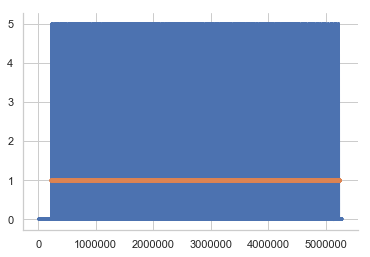

In [36]:
#you might need to run these cells twice to the get the plots for some reason

clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

frame_clock = threshold_detect(clock_voltage, 1)
plt.figure()
plt.plot(clock_voltage)
plt.plot(frame_clock, np.ones(len(frame_clock)), '.')
sns.despine()
plt.show()

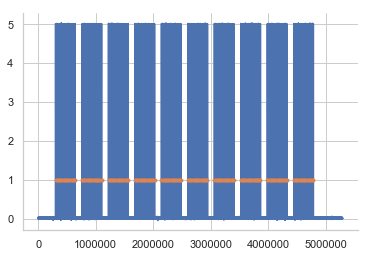

In [37]:
stim_idx = paq['chan_names'].index(stim_name)
stim_volts = paq['data'][stim_idx, :]
stim_times = threshold_detect(stim_volts, 1)

#correct this based on txt file
duration_ms = 250
frame_rate = 30
duration_frames = np.ceil((duration_ms/1000)*frame_rate)
duration_frames = int(duration_frames)

plt.figure()
plt.plot(stim_volts)
plt.plot(stim_times, np.ones(len(stim_times)), '.')
sns.despine()
plt.show()

In [38]:
#get mean intensity for each s2p unit from opsin expression image
opsin_image = tf.imread(opsin_path)

opsin_cell_intensities = []

for i,_ in enumerate(stat):
    y_pixels = stat[i]['ypix']
    x_pixels = stat[i]['xpix']
    
    intensity = []
    
    for y_index,x_index in zip(y_pixels, x_pixels):
        intensity.append(opsin_image[y_index][x_index])

    opsin_cell_intensities.append(np.mean(intensity))
    
opsin_cell_intensities

[342.9115281501341,
 179.92436974789916,
 128.6595744680851,
 231.06024096385542,
 216.27035830618894,
 274.45487364620936,
 338.58555133079847,
 318.90013679890563,
 196.2774193548387,
 296.4839357429719,
 129.7605633802817,
 196.89958158995816,
 220.58357771260998,
 227.8,
 226.03422053231938,
 267.6984126984127,
 147.92737430167597,
 137.87138263665594,
 173.32051282051282,
 152.27385892116183,
 179.01324503311258,
 283.72893772893775,
 285.3032258064516,
 98.22754491017965,
 169.2170542635659,
 201.6595744680851,
 285.26047904191614,
 146.89430894308944,
 214.5701754385965,
 271.2913043478261,
 157.66480446927375,
 278.7438596491228,
 209.48407643312103,
 156.45967741935485,
 179.55092592592592,
 202.03964757709252,
 157.9318181818182,
 87.77310924369748,
 200.68376068376068,
 121.9119170984456,
 245.86451612903227,
 182.69230769230768,
 127.38983050847457,
 86.47852760736197,
 260.640625,
 180.42253521126761,
 214.86013986013987,
 207.79545454545453,
 209.0909090909091,
 236.6,
 1

In [39]:
# work out how many groups in NAPARM from the targets folder + # of 'FOVTargets' files

# lookup recursive for NAPARM target images, find number of stim groups
num_groups = 0
pattern = 'FOVTargets*'
for dirpath, dirnames, filenames in os.walk(naparm_path):

    if not filenames:
        continue

    target_files = fnmatch.filter(filenames, pattern)
    if target_files:
        for i,file in enumerate(target_files):
            num_groups += 1
            print('{}\{}'.format(dirpath, file))
            target_files[i] = dirpath + '\\' + file

# separate stim_times in to groups (np.array?)
groups = np.arange(num_groups)
num_stims = len(stim_times)
num_trials = num_stims//num_groups

stim_times_grouped = np.zeros((num_groups, num_trials))

for i in groups:
    stim_times_grouped[i] = stim_times[i:num_stims:num_groups]

print(stim_times_grouped)

# load target images in loop and find pixels with 255 value, note xy indices for each
target_images = tf.imread(target_files)

targets = np.where(target_images == np.amax(target_images)) #indexed as group index, then y index, then x index
group_list = list(targets[0])
num_targets = []

for group in groups:
    num_targets.append(group_list.count(group))

#find roi xy values of cells from stat?
#compare roi xy values of each cell to all target cells and append index to a list of targeted cells if so
target_units = [[] for i in range(num_groups)]
target_indices = [[] for i in range(num_groups)]

for i,_ in enumerate(stat):
    y_pixels = stat[i]['ypix']
    x_pixels = stat[i]['xpix']
    
    for y_index,y_value in enumerate(targets[1]):
        x_value = targets[2][y_index]
        
        y_values = np.arange(y_value-7,y_value+7)
        x_values = np.arange(x_value-7,x_value+7)
        
        #if y_values in y_pixels and x_values in x_pixels:
        if any(y in y_pixels for y in y_values) and any(x in x_pixels for x in x_values): 
            group_index = targets[0][y_index]
            target_units[group_index].append(stat[i]['original_index'])
            target_indices[group_index].append(i)

print(target_units)
print(target_indices)

C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004\2019-04-25_RL036_NAPARM_004\Targets\FOVTargets_001_2019-04-25_RL036_NAPARM_004.tif
C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004\2019-04-25_RL036_NAPARM_004\Targets\FOVTargets_002_2019-04-25_RL036_NAPARM_004.tif
C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004\2019-04-25_RL036_NAPARM_004\Targets\FOVTargets_003_2019-04-25_RL036_NAPARM_004.tif
C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004\2019-04-25_RL036_NAPARM_004\Targets\FOVTargets_004_2019-04-25_RL036_NAPARM_004.tif
C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photostim responsivity\RL036\2019-04-25_RL036_t-004\2019-04-25_RL036_NAPARM_004\Targets\FOVTargets_005_2019-04-25_RL036_NAPARM_004.tif
C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Photost

In [40]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim >= 0)
    stim_start_frames.append(stim_start_frame)
    
stim_start_frames = np.array(stim_start_frames)

#sanity check
assert max(stim_start_frames) < arr.shape[1]

stim_frames_grouped = np.empty((num_groups, num_trials))

for i in groups:
    stim_frames_grouped[i] = stim_start_frames[i:num_stims:num_groups]
    
stim_frames_grouped

array([[ 110.,  797., 1484., 2171., 2858., 3545., 4232., 4920., 5607.,
        6294.],
       [ 140.,  827., 1514., 2201., 2888., 3575., 4262., 4949., 5636.,
        6324.],
       [ 170.,  857., 1544., 2231., 2918., 3605., 4292., 4979., 5666.,
        6353.],
       [ 199.,  886., 1574., 2261., 2948., 3635., 4322., 5009., 5696.,
        6383.],
       [ 229.,  916., 1603., 2291., 2978., 3665., 4352., 5039., 5726.,
        6413.],
       [ 259.,  946., 1633., 2320., 3008., 3695., 4382., 5069., 5756.,
        6443.],
       [ 289.,  976., 1663., 2350., 3037., 3725., 4412., 5099., 5786.,
        6473.],
       [ 319., 1006., 1693., 2380., 3067., 3754., 4442., 5129., 5816.,
        6503.],
       [ 349., 1036., 1723., 2410., 3097., 3784., 4471., 5158., 5846.,
        6533.],
       [ 379., 1066., 1753., 2440., 3127., 3814., 4501., 5188., 5875.,
        6563.],
       [ 409., 1096., 1783., 2470., 3157., 3844., 4531., 5218., 5905.,
        6592.],
       [ 438., 1125., 1813., 2500., 3187., 

In [41]:
#pick a group to analyse (indexing starts at 0)
#group_i = 0

#this is the key parameter for the sta, how many frames before and after the stim do you want to use
pre_frames = 30
post_frames = 30

#list of cell pixel intensity values during each stim on each trial
all_trials_grouped = []

# the average of every trial
stas_grouped = []

sta_amplitudes_grouped = []

t_tests_grouped = []
mann_whits_grouped = []

for group_i in groups:
    
    #list of cell pixel intensity values during each stim on each trial
    all_trials = []

    # the average of every trial
    stas = []

    sta_amplitudes = []
    
    t_tests = []
    mann_whits = []

    #loop through each cell
    for i, unit in enumerate(arr):

        trials = []
        df = []
        amplitudes = []

        # a flat list of all observations before stim occured
        pre_obs = []
        # a flat list of all observations after stim occured
        post_obs = []

        for stim in stim_frames_grouped[group_i]:
            stim = int(stim)
            
            # get baseline values from pre_stim
            pre_stim  = unit[stim-pre_frames : stim]
            baseline = np.mean(pre_stim)
            
            # the whole trial and dfof using baseline
            trial = unit[stim-pre_frames : stim+post_frames]
            trial = [((f-baseline)/ baseline) * 100 for f in trial]
            trials.append(trial)
            
            pre_stim  = trial[ : pre_frames-1]
            post_stim = trial[pre_frames : ]

            # append to flat lists
            [pre_obs.append(ob) for ob in pre_stim]
            [post_obs.append(ob) for ob in post_stim]

            #calc amplitude of response        
            pre_f = trial[pre_frames-10 : pre_frames]
            pre_f = np.mean(pre_f)
            post_stim_frame = pre_frames + duration_frames
            post_f = trial[post_stim_frame : post_stim_frame+10]
            post_f = np.mean(post_stim)
            amplitude = post_f - pre_f
            amplitudes.append(amplitude)

        all_trials.append(trials)

        #average amplitudes across trials
        all_amplitudes = np.array(amplitudes)
        sta_amplitude = np.mean(all_amplitudes,0)
        sta_amplitudes.append(sta_amplitude)

        #average across all trials
        sta = np.mean(trials, 0)        
        stas.append(sta)

        #remove nans from flat lists
        pre_obs = [x for x in pre_obs if ~np.isnan(x)]
        post_obs = [x for x in post_obs if ~np.isnan(x)]

        #t_test and man whit test pre and post stim (any other test could also be used here)
        t_test = stats.ttest_ind(pre_obs, post_obs)
        t_tests.append(t_test)

        mann_whit = stats.mannwhitneyu(pre_obs, post_obs)
        mann_whits.append(mann_whit)
    
    # the average of every trial
    stas_grouped.append(stas)
    
    # list of cell pixel intensity values during each stim on each trial
    all_trials_grouped.append(all_trials)   
    
    t_tests_grouped.append(t_tests)
    mann_whits_grouped.append(mann_whits)

    sta_amplitudes_grouped.append(sta_amplitudes)

stas_grouped = np.array(stas_grouped)
all_trials_grouped = np.array(all_trials_grouped)
sta_amplitudes_grouped = np.array(sta_amplitudes_grouped)
t_tests_grouped = np.array(t_tests_grouped)
mann_whits_grouped = np.array(mann_whits_grouped)

In [42]:
all_trials_grouped.shape

(18, 279, 10, 60)

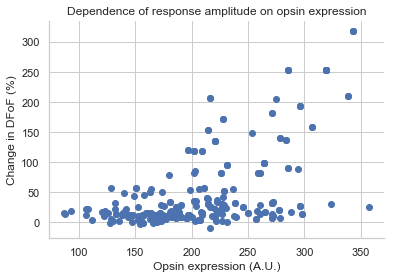

In [43]:
x_axis = []
y_axis = []

for group_i in groups:
    target_i = np.array(target_indices[group_i])

    for i in target_i:
        x_axis.append(opsin_cell_intensities[i])
        y_axis.append(sta_amplitudes_grouped[group_i,i])

plt.figure()
plt.scatter(x_axis, y_axis)
plt.title('Dependence of response amplitude on opsin expression')
plt.xlabel('Opsin expression (A.U.)')
plt.ylabel('Change in DFoF (%)')
sns.despine()
plt.show()

np.save(s2p_path + '_opsin_int.npy', x_axis)
np.save(s2p_path + '_sta_amp.npy', y_axis)

In [32]:
#set this to true if you want to multiple comparisons correct for the number of cells
multi_comp_correction = True
if not multi_comp_correction: 
    divisor = 1
else:
    divisor = num_units

In [33]:
#choose group to analyse + plot
group_i = 1

p_vals = [t[1] for t in t_tests_grouped[group_i]]
idx = range(len(p_vals))

if multi_comp_correction:
    print('performing t-test on cells with mutliple comparisons correction')
else:
    print('performing t-test on cells without mutliple comparisons correction')
    
count = 0
sig_units = []
for p,i in sorted(zip(p_vals,idx)):
    if p < 0.05 / divisor:
        count += 1
        unit_index = stat[i]['original_index']
        if unit_index in target_units[group_i]: target_boolean = 'yes' 
        else: target_boolean = 'no' 
        print('Stim {} significantly changed fluoresence of s2p unit {}, its P value is {}. Target? {}'.format(group_i,unit_index, p, target_boolean))
        sig_units.append(i) #significant units

performing t-test on cells with mutliple comparisons correction
Stim 1 significantly changed fluoresence of s2p unit 48, its P value is 4.747810306918599e-114. Target? yes
Stim 1 significantly changed fluoresence of s2p unit 19, its P value is 6.025308560010599e-38. Target? no
Stim 1 significantly changed fluoresence of s2p unit 77, its P value is 4.104267450711852e-34. Target? no
Stim 1 significantly changed fluoresence of s2p unit 82, its P value is 1.4916144039575181e-32. Target? no
Stim 1 significantly changed fluoresence of s2p unit 22, its P value is 1.4513776238960201e-31. Target? no
Stim 1 significantly changed fluoresence of s2p unit 23, its P value is 3.972674995701414e-26. Target? no
Stim 1 significantly changed fluoresence of s2p unit 28, its P value is 8.263162922221473e-24. Target? no
Stim 1 significantly changed fluoresence of s2p unit 56, its P value is 2.5346796334303266e-15. Target? no
Stim 1 significantly changed fluoresence of s2p unit 30, its P value is 1.104243913

C:\Users\roble\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


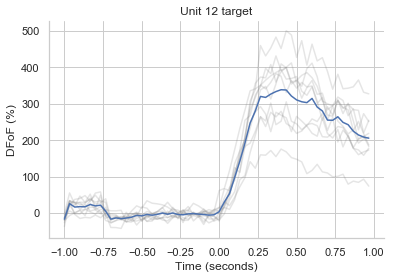

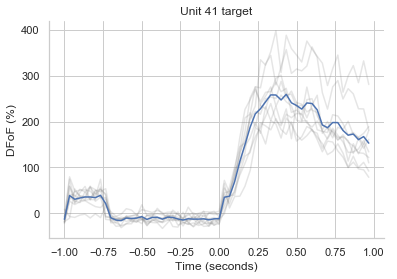

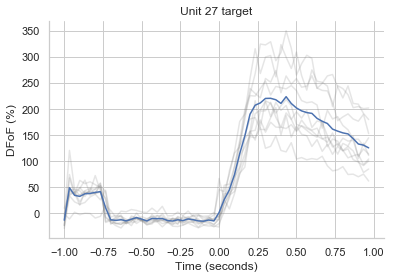

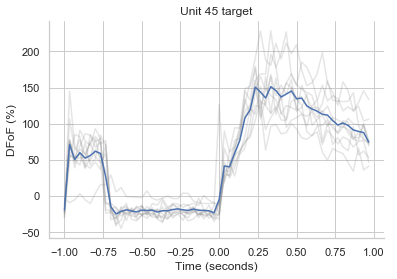

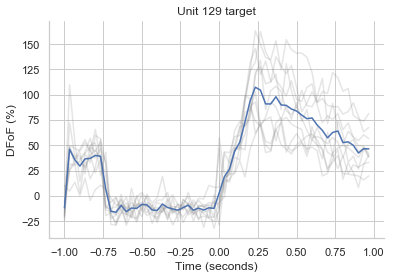

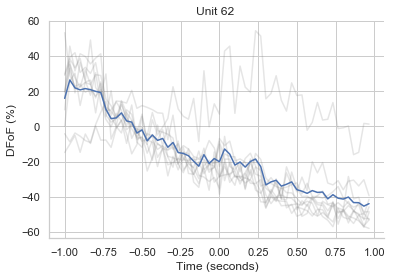

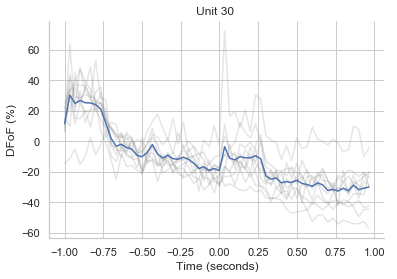

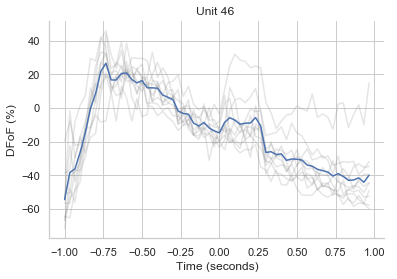

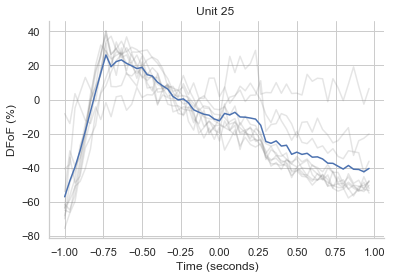

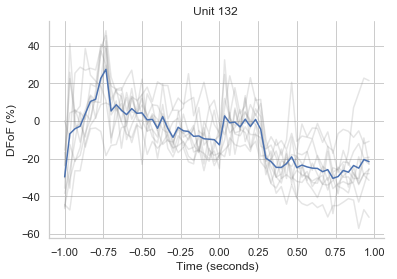

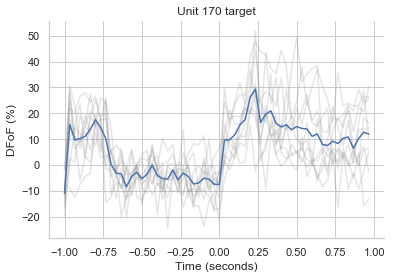

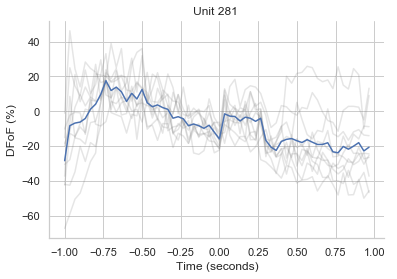

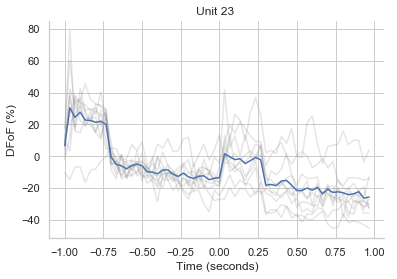

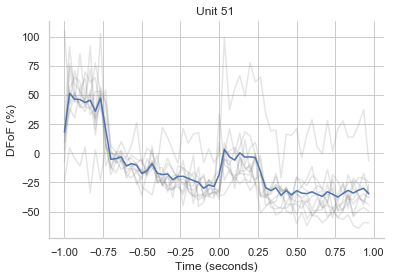

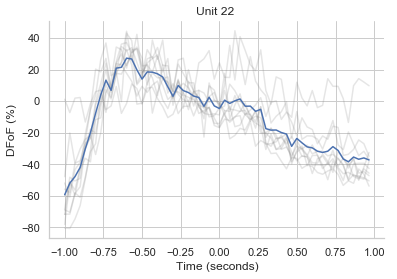

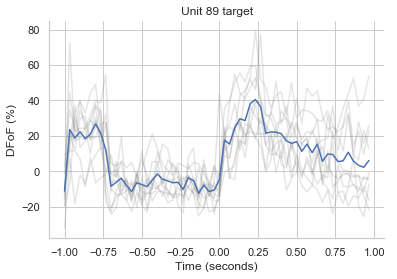

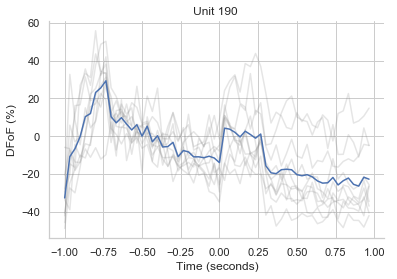

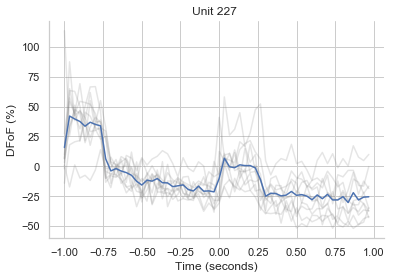

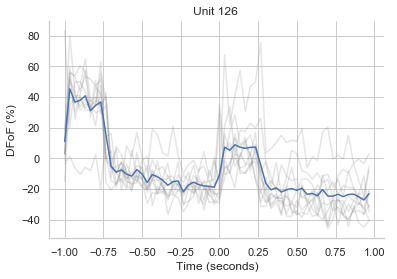

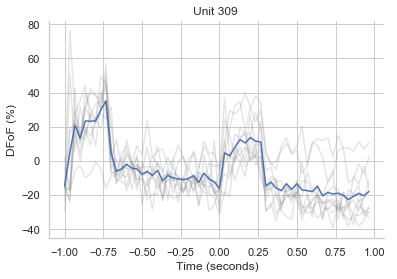

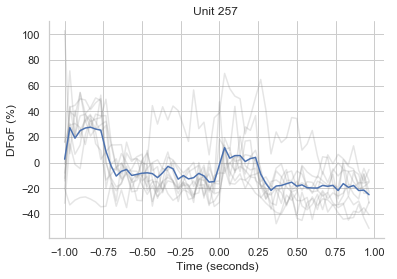

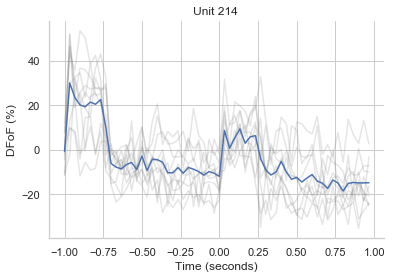

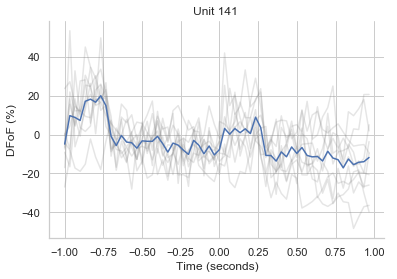

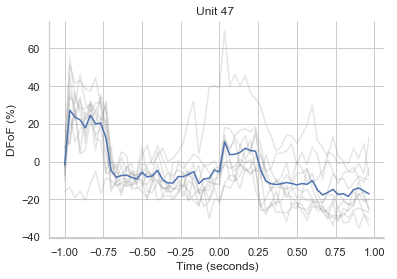

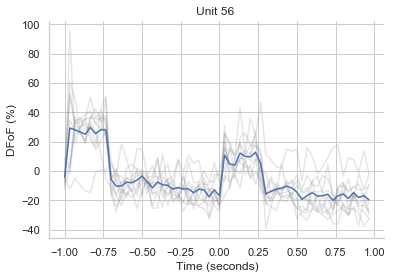

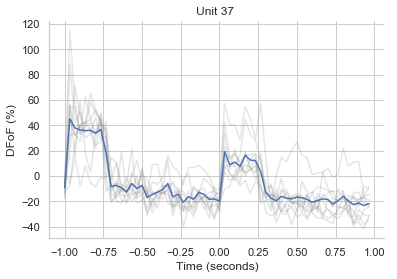

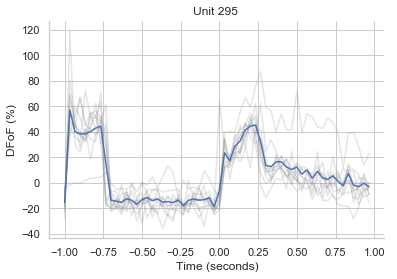

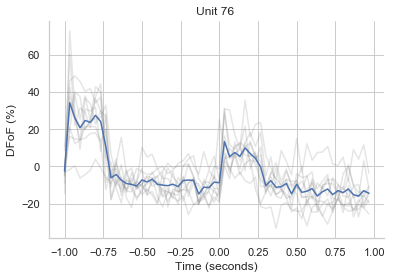

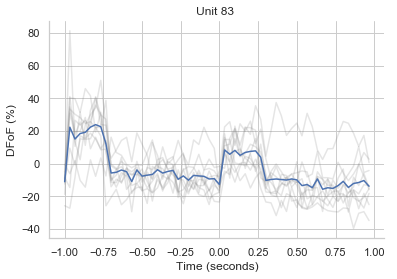

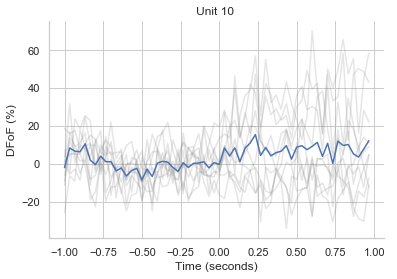

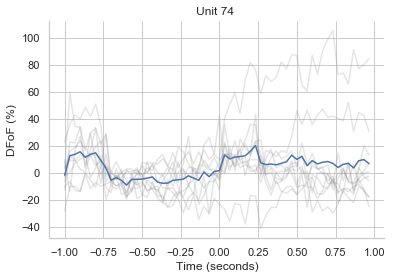

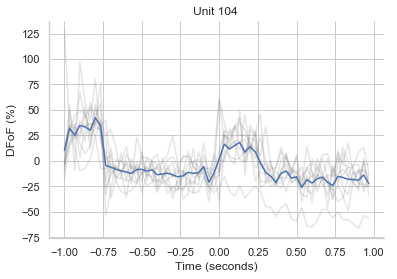

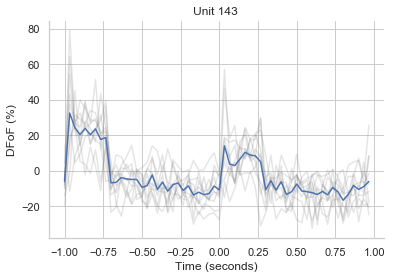

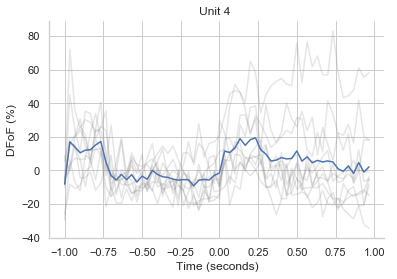

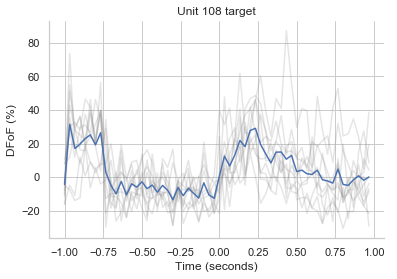

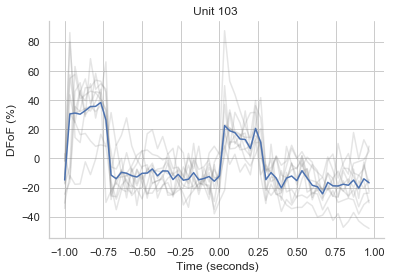

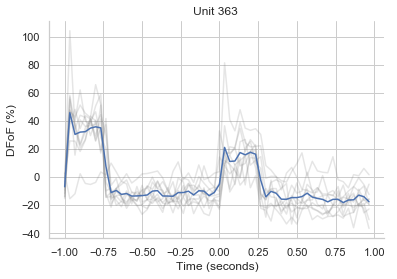

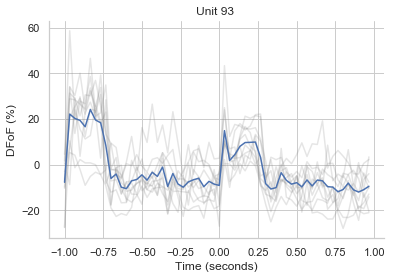

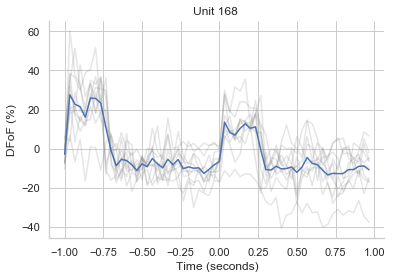

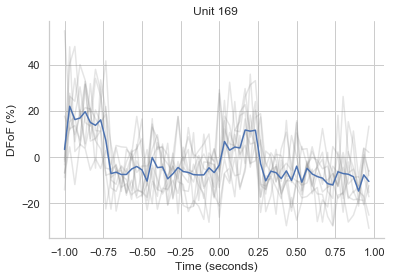

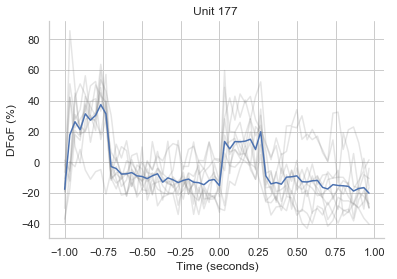

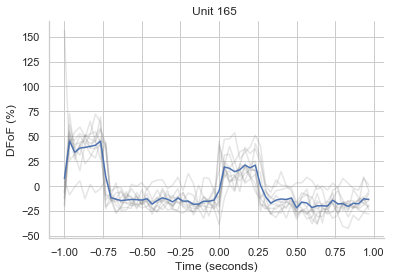

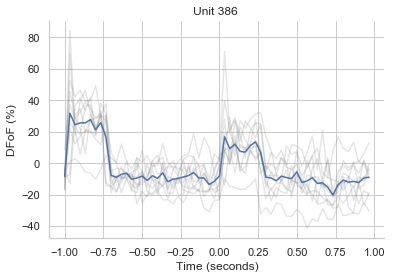

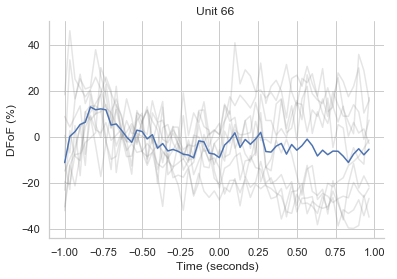

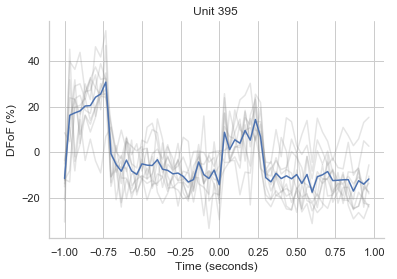

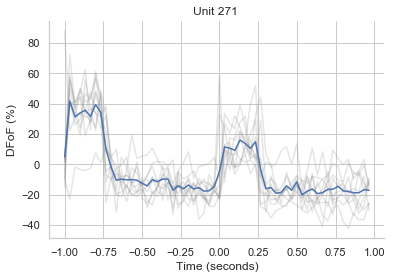

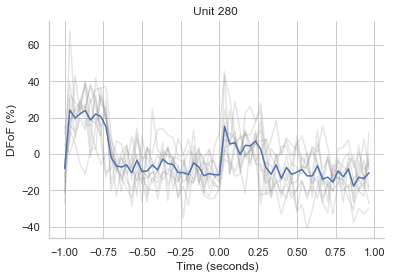

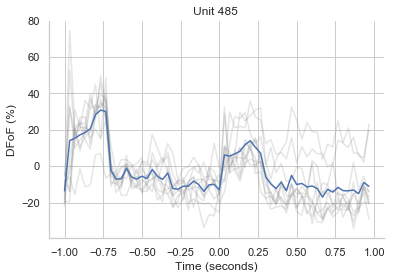

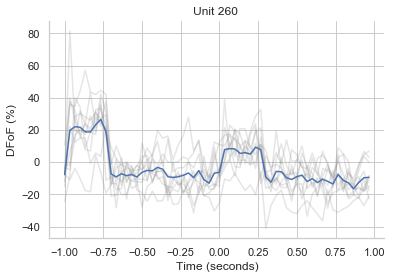

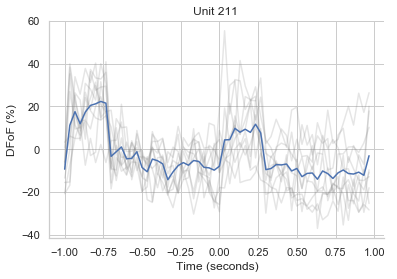

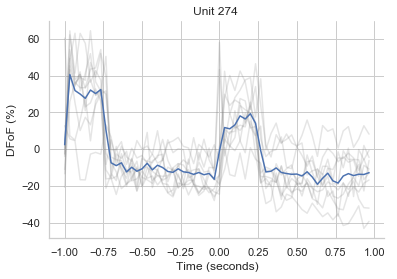

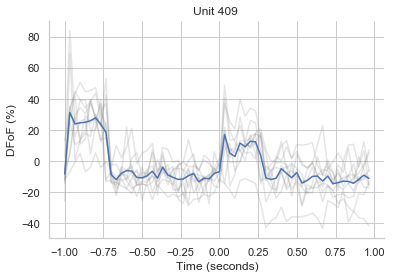

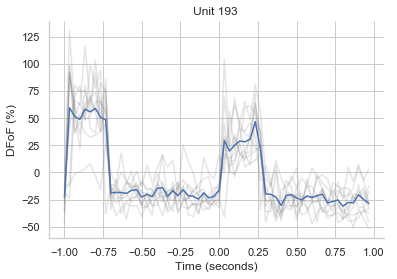

In [19]:
#set the unit number here you want to plot
for i in sig_units:
    unit = i
    unit_index = stat[i]['original_index']
    
    if unit_index in target_units[group_i]: 
        target_report = 'target' 
    else:
        target_report = ''
    
    frame_rate = 30
    x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

    plt.figure()

    sta = stas_grouped[group_i][unit]
    [plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials_grouped[group_i,unit,:,:]]
    plt.plot(x_axis, sta)
    plt.title('Unit ' + str(unit_index) + ' ' + target_report)
    plt.xlabel('Time (seconds)')
    plt.ylabel('DFoF (%)')
    #plt.ylim((-100,200))
    sns.despine()
    #plt.savefig('s2_responsive_cell.pdf')

r-squared: 0.22480238596964866
p-value: 1.9935324990872468e-16
slope: 0.2169986376783291
r-squared: 0.17675463649229153
p-value: 1.1621548872296933e-10
slope: 0.3228691914740584
r-squared: 0.3610390387179681
p-value: 6.31734479942849e-06
slope: 0.12166431227891583


C:\Users\roble\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
C:\Users\roble\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


r-squared: 0.3695923554703842
p-value: 1.0957358668862584e-20
slope: 0.11667842418434161
r-squared: 0.19868005850678316
p-value: 2.774612198865405e-12
slope: 0.11139488800586111
r-squared: 0.14445150540117285
p-value: 1.582472872750697e-09
slope: 0.1389525868640015


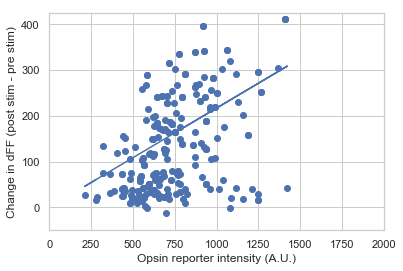

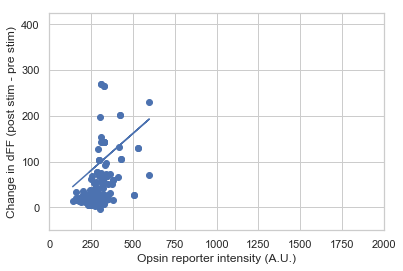

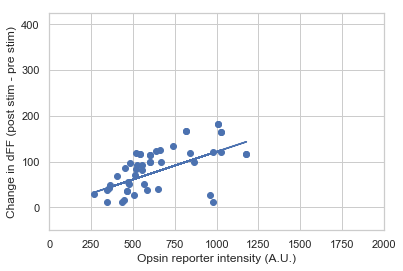

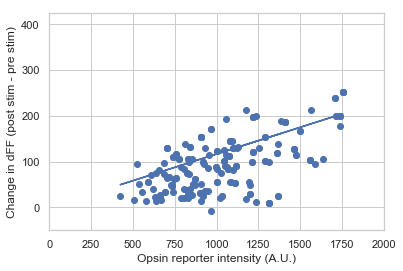

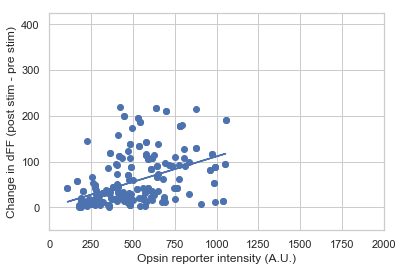

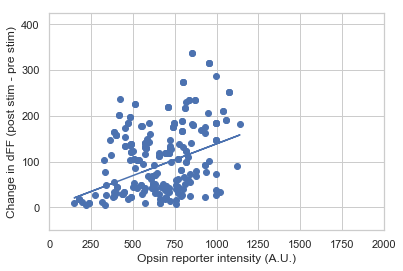

In [53]:
path = [1, 4, 5, 6, 7, 9]
num_files = len(path)

opsin = [[] for i,_ in enumerate(path)]
sta_amp = [[] for i,_ in enumerate(path)]

for i,p in enumerate(path):
    opsin[i] = np.load(r"C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Finding targeted cells\opsin_t-00" + str(p) + ".npy")
    sta_amp[i] = np.load(r"C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Finding targeted cells\sta_amp_t-00" + str(p) + ".npy")

# filter out extreme values over 2000 dff change#
# fig = plt.figure()
# ax1 = fig.add_subplot(111)

for fov_ind in range(num_files):
    plt.figure()
    keep_idx = np.where((sta_amp[fov_ind] > -2000) & (sta_amp[fov_ind] < 2000))
    sta_amp[fov_ind] = sta_amp[fov_ind][keep_idx]
    opsin[fov_ind] = opsin[fov_ind][keep_idx]
#     ax1.scatter(opsin[fov_ind], sta_amp[fov_ind])
    
    plt.scatter(opsin[fov_ind], sta_amp[fov_ind])
    slope, intercept, r_value, p_value, std_err = stats.linregress(opsin[fov_ind],sta_amp[fov_ind])
    print ("r-squared:", r_value**2)
    print ("p-value:", p_value)
    print("slope:", slope)
    y = slope*opsin[fov_ind]
    plt.plot(opsin[fov_ind], y)
    plt.axis([0, 2000, -50, 425])
    plt.xlabel('Opsin reporter intensity (A.U.)')
    plt.ylabel('Change in dFF (post stim - pre stim)')
    plt.savefig(r'C:\Users\roble\Documents\Packer lab\Lab meetings\2019-05-08_show_and_tell\2019-05-07_opsin_vs_staAmplitudes_' + str(fov_ind) + '.svg')

# opsin = [y for x in opsin for y in x]
#sta_amp = [y for x in sta_amp for y in x]
# plt.scatter(opsin, sta_amp)

# for i,_ in enumerate(opsin):
#     print(len(opsin[i]))

# plt.show()
# plt.savefig(r'C:\Users\roble\Documents\Packer lab\Lab meetings\2019-05-08_show_and_tell\2019-05-07_opsin_vs_staAmplitudes_grouped.svg')

In [45]:
path = r'C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\STA amplitudes and opsin intensities'

all_amplitudes = []

for dirpath, dirnames, filenames in os.walk(path):
    
    for file in filenames:
        amplitudes = np.load(os.path.join(path, file))
        all_amplitudes.append(amplitudes)
        
all_amplitudes = [amplitude for amplitudes in all_amplitudes for amplitude in amplitudes]

C:\Users\roble\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\roble\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


ValueError: cannot convert float NaN to integer

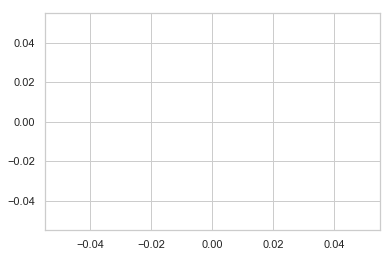

In [51]:
plt.figure
#plt.boxplot(all_amplitudes, notch=True)
sns.distplot(all_amplitudes, bini)
plt.axis([-100, 500, 0, 0.085])
#plt.savefig()